# Projet Air Paradis - Analyse de sentiment des tweets

Ce notebook présente la préparation des données et le prétraitement des tweets pour le projet Air Paradis.

## Objectif

Développer un système IA capable de prédire le sentiment (positif/négatif) associé à des tweets.

## Étapes de ce notebook

1. Chargement des données
2. Exploration et analyse des tweets
3. Prétraitement du texte
4. Préparation des jeux de données (train/validation/test)
5. Stockage des données prétraitées

## 1. Configuration de l'environnement et importation des librairies

In [18]:
# Importation des librairies nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
import os
import mlflow
import mlflow.sklearn

# Pour le prétraitement du texte
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Pour les métriques d'évaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Téléchargement des ressources NLTK nécessaires
print("Téléchargement des ressources NLTK...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
print("Téléchargement terminé.")

# Configuration de MLflow
mlflow.set_experiment("air_paradis_sentiment_analysis")

Téléchargement des ressources NLTK...
Téléchargement terminé.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tonton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tonton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tonton\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<Experiment: artifact_location='file:///c:/Tonton/OpenClassrooms/Projet_6_realiser_une_analyse_de_sentiments_grace_au_deep_learning/tests/mlruns/734193718066391964', creation_time=1745165201016, experiment_id='734193718066391964', last_update_time=1745165201016, lifecycle_stage='active', name='air_paradis_sentiment_analysis', tags={}>

## 2. Chargement des données

In [19]:
# Chemin vers le fichier de données
data_path = "../data/training.1600000.processed.noemoticon.csv"

# Noms des colonnes basés sur l'analyse du fichier
column_names = ['sentiment', 'user_id', 'timestamp', 'query', 'username', 'tweet']

# Chargement des données
print("Chargement des données...")
df = pd.read_csv(data_path, encoding='latin-1', header=None, names=column_names)
print(f"Données chargées : {df.shape[0]} lignes et {df.shape[1]} colonnes")

# Affichage des premières lignes
print("\nAperçu des données :")
display(df.head())

Chargement des données...
Données chargées : 1600000 lignes et 6 colonnes

Aperçu des données :


,sentiment,user_id,timestamp,query,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## 3. Exploration des données

In [20]:
# Informations générales sur le dataset
print("Informations sur le dataset :")
display(df.info())

# Statistiques descriptives
print("\nStatistiques descriptives :")
display(df.describe())

# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
display(df.isnull().sum())

Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   user_id    1600000 non-null  int64 
 2   timestamp  1600000 non-null  object
 3   query      1600000 non-null  object
 4   username   1600000 non-null  object
 5   tweet      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


None


Statistiques descriptives :


,sentiment,user_id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09



Valeurs manquantes par colonne :


sentiment    0
user_id      0
timestamp    0
query        0
username     0
tweet        0
dtype: int64

### 3.1 Analyse de la distribution des sentiments

Distribution des sentiments :


sentiment_label
Négatif    800000
Positif    800000
Name: count, dtype: int64

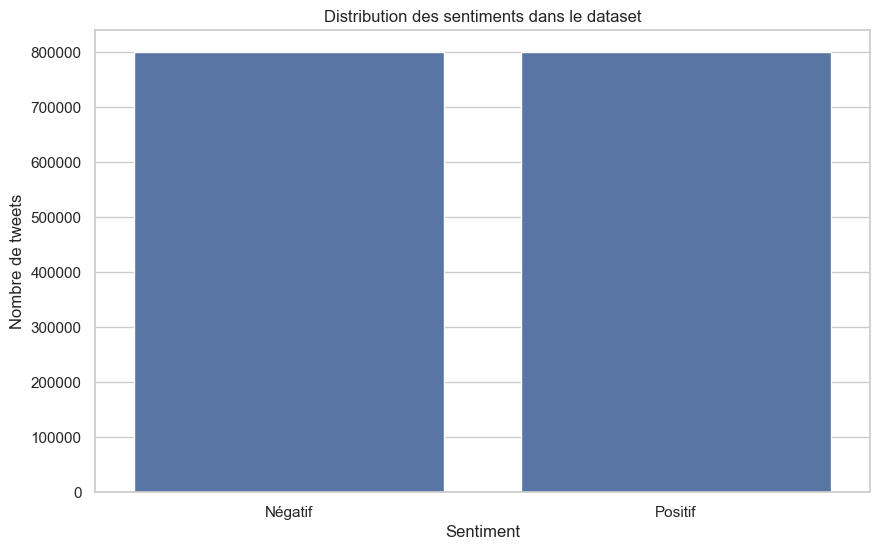


Pourcentage par sentiment :
Négatif: 50.00%
Positif: 50.00%


In [21]:
# Conversion des valeurs de sentiment (0->négatif, 4->positif)
df['sentiment_label'] = df['sentiment'].map({0: 'Négatif', 4: 'Positif'})

# Distribution des sentiments
sentiment_counts = df['sentiment_label'].value_counts()
print("Distribution des sentiments :")
display(sentiment_counts)

# Visualisation de la distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment_label')
plt.title('Distribution des sentiments dans le dataset')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de tweets')
plt.show()

# Vérification du pourcentage
sentiment_percentage = sentiment_counts / len(df) * 100
print("\nPourcentage par sentiment :")
for sentiment, percentage in sentiment_percentage.items():
    print(f"{sentiment}: {percentage:.2f}%")

### 3.2 Analyse des caractéristiques textuelles des tweets

Statistiques sur la longueur des tweets :


,char_count,word_count
count,1.600000e+06,1.600000e+06
mean,7.409011e+01,1.317615e+01
std,3.644114e+01,6.957978e+00
min,6.000000e+00,1.000000e+00
25%,4.400000e+01,7.000000e+00
50%,6.900000e+01,1.200000e+01
75%,1.040000e+02,1.900000e+01
max,3.740000e+02,6.400000e+01


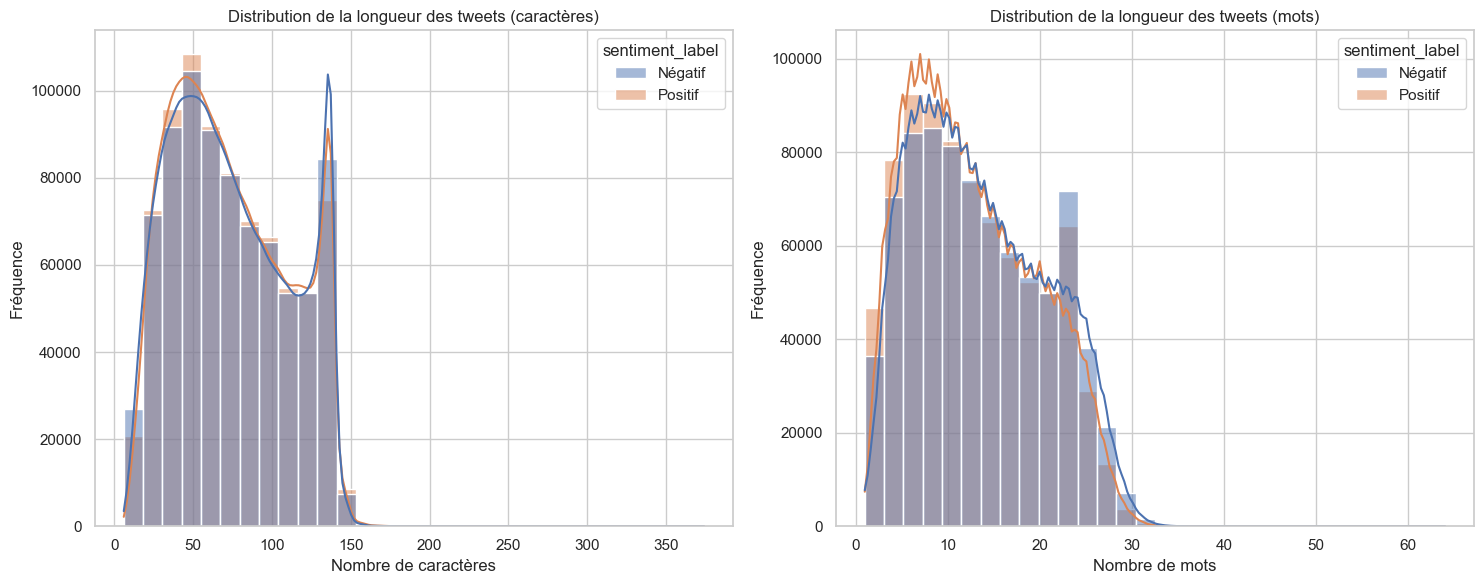


Longueur moyenne des tweets par sentiment :


,char_count,word_count
sentiment_label,,
Négatif,74.301790,13.581984
Positif,73.878433,12.770318


In [22]:
# Fonction pour calculer la longueur des tweets (en caractères et en mots)
df['char_count'] = df['tweet'].apply(len)
df['word_count'] = df['tweet'].apply(lambda x: len(x.split()))

# Statistiques sur la longueur des tweets
print("Statistiques sur la longueur des tweets :")
display(df[['char_count', 'word_count']].describe())

# Visualisation de la distribution de la longueur des tweets
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='char_count', hue='sentiment_label', bins=30, kde=True)
plt.title('Distribution de la longueur des tweets (caractères)')
plt.xlabel('Nombre de caractères')
plt.ylabel('Fréquence')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='word_count', hue='sentiment_label', bins=30, kde=True)
plt.title('Distribution de la longueur des tweets (mots)')
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

# Longueur moyenne par sentiment
print("\nLongueur moyenne des tweets par sentiment :")
display(df.groupby('sentiment_label')[['char_count', 'word_count']].mean())

### 3.3 Analyse des éléments spécifiques à Twitter

Statistiques sur les éléments spécifiques à Twitter :


,mentions,hashtags,urls
count,1.600000e+06,1.600000e+06,1.600000e+06
mean,4.916306e-01,2.754188e-02,4.471250e-02
std,5.879032e-01,2.241642e-01,2.115114e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,0.000000e+00,0.000000e+00
max,1.200000e+01,2.400000e+01,5.000000e+00


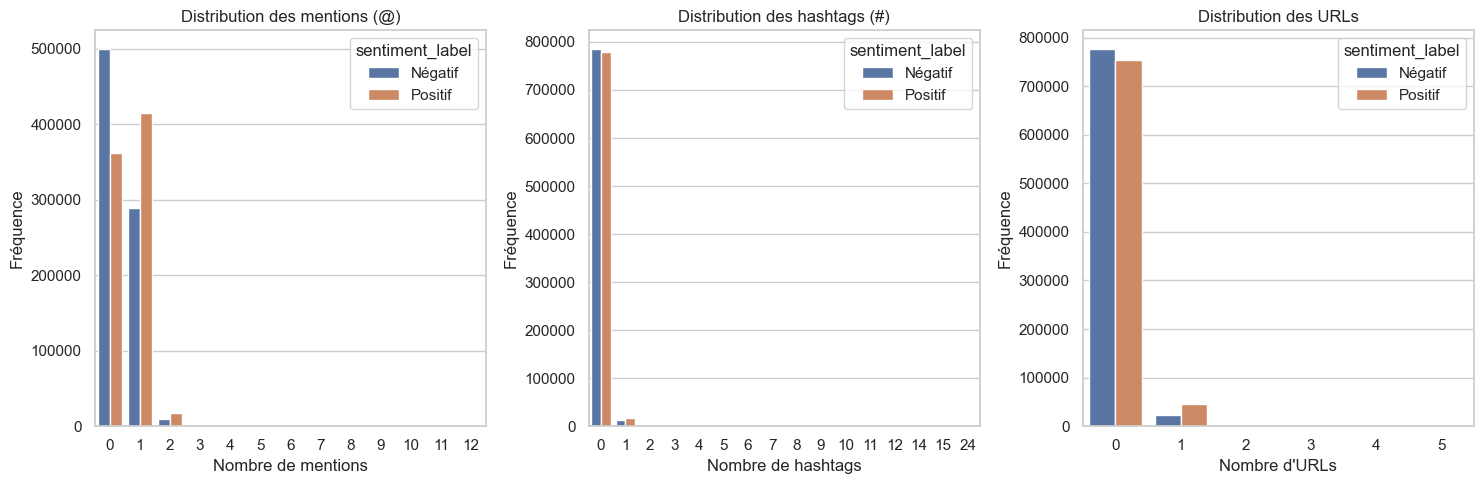

In [23]:
# Fonction pour compter les éléments spécifiques à Twitter
def count_twitter_elements(text):
    # Compter les mentions (@)
    mentions = len(re.findall(r'@\w+', text))
    
    # Compter les hashtags (#)
    hashtags = len(re.findall(r'#\w+', text))
    
    # Compter les URLs
    urls = len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text))
    
    return mentions, hashtags, urls

# Application de la fonction sur le dataset
df['mentions'], df['hashtags'], df['urls'] = zip(*df['tweet'].apply(count_twitter_elements))

# Statistiques sur les éléments Twitter
print("Statistiques sur les éléments spécifiques à Twitter :")
display(df[['mentions', 'hashtags', 'urls']].describe())

# Visualisation
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=df, x='mentions', hue='sentiment_label')
plt.title('Distribution des mentions (@)')
plt.xlabel('Nombre de mentions')
plt.ylabel('Fréquence')

plt.subplot(1, 3, 2)
sns.countplot(data=df, x='hashtags', hue='sentiment_label')
plt.title('Distribution des hashtags (#)')
plt.xlabel('Nombre de hashtags')
plt.ylabel('Fréquence')

plt.subplot(1, 3, 3)
sns.countplot(data=df, x='urls', hue='sentiment_label')
plt.title('Distribution des URLs')
plt.xlabel('Nombre d\'URLs')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

### 3.4 Analyse des mots les plus fréquents

20 mots les plus fréquents dans les tweets positifs :


,Mot,Fréquence
0,im,74853
1,good,60846
2,love,46839
3,day,44363
4,like,37108
5,get,36168
6,thanks,33723
7,lol,33470
8,going,30647
9,u,30160



20 mots les plus fréquents dans les tweets négatifs :


,Mot,Fréquence
0,im,102625
1,get,45316
2,go,45126
3,dont,44913
4,work,44057
5,cant,43591
6,like,40640
7,day,38000
8,today,36190
9,going,33440


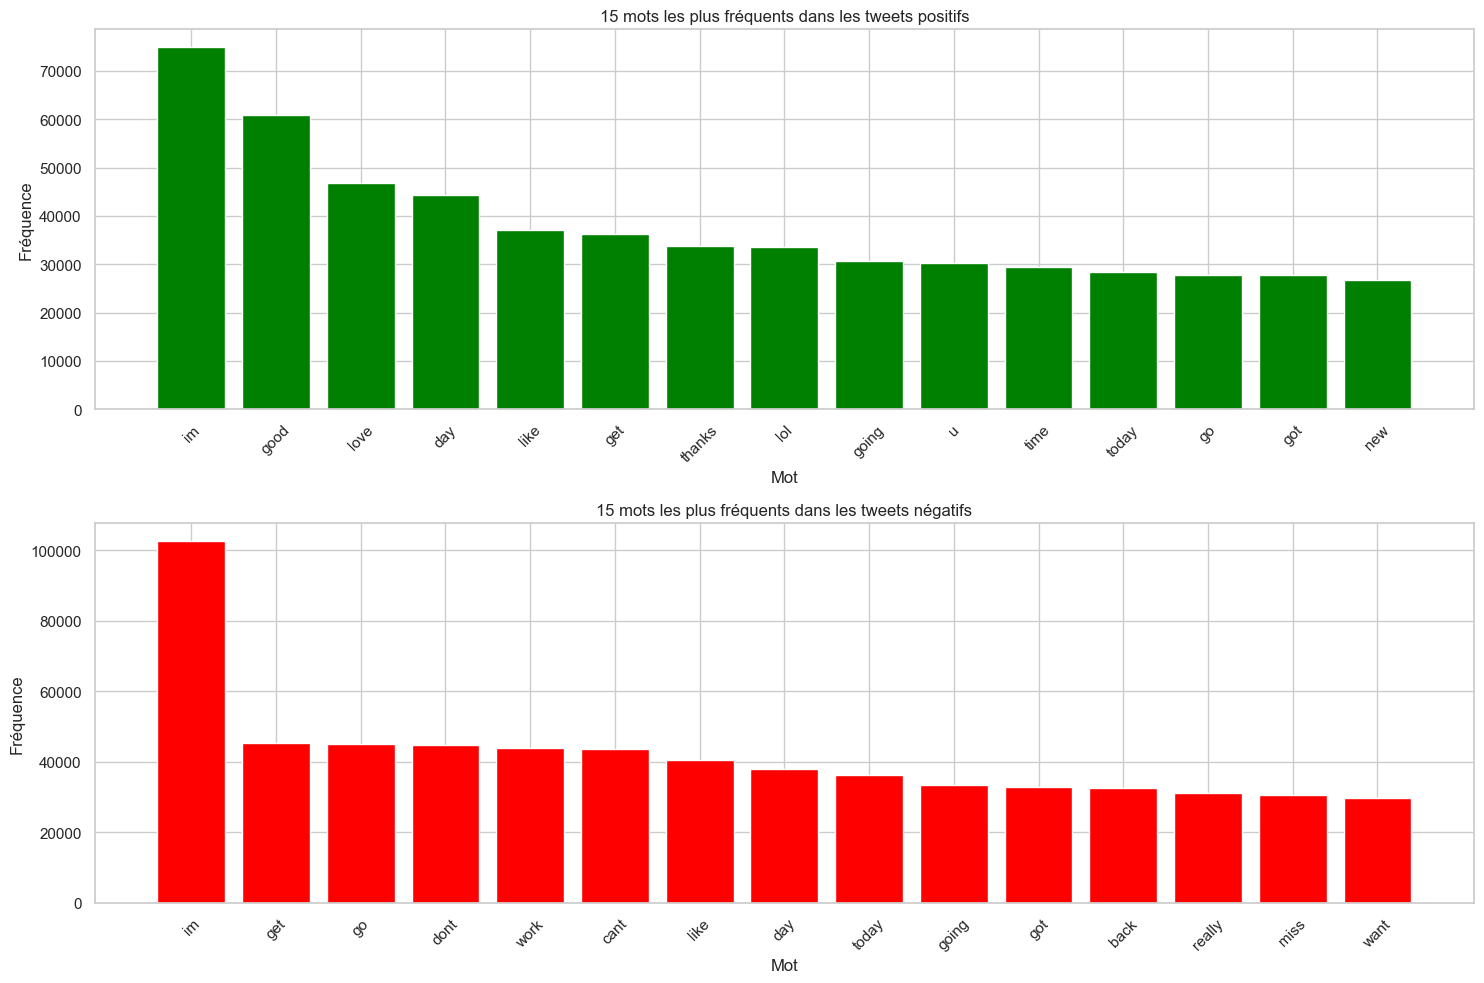

In [24]:
# Fonction pour extraire les mots d'un texte
def extract_words(text):
    # Conversion en minuscules
    text = text.lower()
    
    # Suppression de la ponctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenisation
    words = text.split()
    
    # Suppression des stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    return words

# Extraction des mots pour chaque sentiment
positive_tweets = df[df['sentiment'] == 4]['tweet']
negative_tweets = df[df['sentiment'] == 0]['tweet']

positive_words = []
for tweet in positive_tweets:
    positive_words.extend(extract_words(tweet))

negative_words = []
for tweet in negative_tweets:
    negative_words.extend(extract_words(tweet))

# Comptage des mots les plus fréquents
from collections import Counter

positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)

# Affichage des 20 mots les plus fréquents pour chaque sentiment
print("20 mots les plus fréquents dans les tweets positifs :")
display(pd.DataFrame(positive_word_counts.most_common(20), columns=['Mot', 'Fréquence']))

print("\n20 mots les plus fréquents dans les tweets négatifs :")
display(pd.DataFrame(negative_word_counts.most_common(20), columns=['Mot', 'Fréquence']))

# Visualisation
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
top_positive = dict(positive_word_counts.most_common(15))
plt.bar(top_positive.keys(), top_positive.values(), color='green')
plt.title('15 mots les plus fréquents dans les tweets positifs')
plt.xlabel('Mot')
plt.ylabel('Fréquence')
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
top_negative = dict(negative_word_counts.most_common(15))
plt.bar(top_negative.keys(), top_negative.values(), color='red')
plt.title('15 mots les plus fréquents dans les tweets négatifs')
plt.xlabel('Mot')
plt.ylabel('Fréquence')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 4. Prétraitement des données textuelles

### 4.1 Définition des fonctions de prétraitement

In [25]:
# Fonction de prétraitement complète pour les tweets
def preprocess_tweet(tweet):
    """
    Fonction pour prétraiter un tweet:
    1. Conversion en minuscules
    2. Suppression des mentions (@user)
    3. Suppression des URLs
    4. Suppression des hashtags (#)
    5. Suppression des caractères spéciaux et de la ponctuation
    6. Tokenisation
    7. Suppression des stopwords
    8. Lemmatisation
    """
    # Conversion en minuscules
    tweet = tweet.lower()
    
    # Suppression des mentions
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Suppression des URLs
    tweet = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet)
    
    # Suppression des hashtags (on garde le mot sans #)
    tweet = re.sub(r'#(\w+)', r'\1', tweet)
    
    # Suppression des caractères spéciaux et de la ponctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    
    # Suppression des chiffres
    tweet = re.sub(r'\d+', '', tweet)
    
    # Tokenisation
    tokens = word_tokenize(tweet)
    
    # Suppression des stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Reconstruction du texte
    processed_tweet = ' '.join(tokens)
    
    return processed_tweet

### 4.2 Application du prétraitement aux données

In [26]:
# Application de la fonction de prétraitement à tous les tweets
print("Application du prétraitement...")
df['processed_tweet'] = df['tweet'].apply(preprocess_tweet)
print("Prétraitement terminé.")

# Affichage de quelques exemples avant/après prétraitement
print("\nExemples de tweets avant et après prétraitement :")
examples = df[['tweet', 'processed_tweet', 'sentiment_label']].sample(5)
display(examples)

Application du prétraitement...
Prétraitement terminé.

Exemples de tweets avant et après prétraitement :


,tweet,processed_tweet,sentiment_label
1415986,@lakersnation Im from orlando... Lakers is my ...,im orlando lakers team didnt expect magic fina...,Positif
1273890,pf changs in my faceeeeeeeeeeeeeee ooh so good,pf chang faceeeeeeeeeeeeeee ooh good,Positif
1056649,@DeejayKnight hahaha. awesome. well you look l...,hahaha awesome well look like ba work im glad ...,Positif
398076,@sillysillyboy How very dare you! I should sla...,dare slap rudeness,Négatif
954345,Bossanova is soooo poolside or Beit 7.. I just...,bossanova soooo poolside beit want bombay chai...,Positif


### 4.3 Analyse des tweets prétraités

Statistiques sur la longueur des tweets prétraités :


,processed_char_count,processed_word_count
count,1.600000e+06,1.600000e+06
mean,4.255683e+01,7.193686e+00
std,2.402711e+01,3.962624e+00
min,0.000000e+00,0.000000e+00
25%,2.300000e+01,4.000000e+00
50%,3.900000e+01,7.000000e+00
75%,6.000000e+01,1.000000e+01
max,1.790000e+02,3.700000e+01


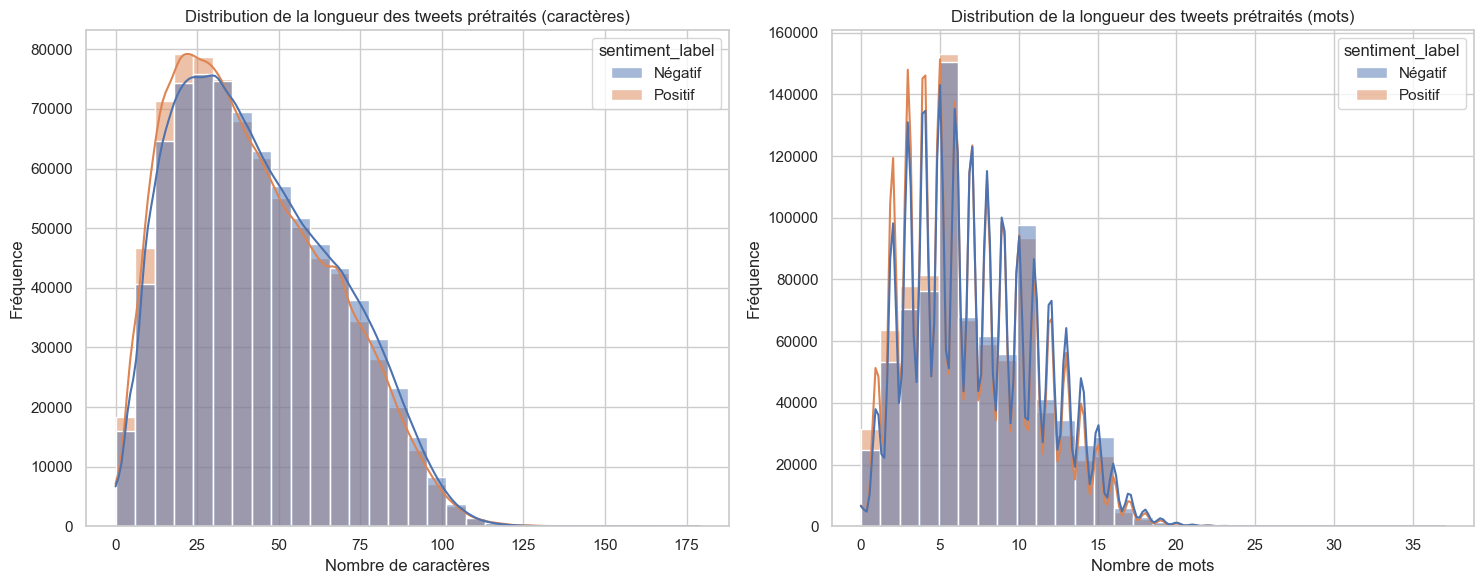

15 mots les plus fréquents dans les tweets positifs après prétraitement :


,Mot,Fréquence
0,im,74891
1,good,60931
2,day,53960
3,love,49502
4,u,38161
5,get,38092
6,like,37947
7,thanks,33819
8,lol,33510
9,time,33197



15 mots les plus fréquents dans les tweets négatifs après prétraitement :


,Mot,Fréquence
0,im,102671
1,day,50055
2,get,47839
3,go,47633
4,work,45569
5,dont,44922
6,cant,43606
7,like,41150
8,got,38207
9,today,36896


In [27]:
# Statistiques sur la longueur des tweets prétraités
df['processed_char_count'] = df['processed_tweet'].apply(len)
df['processed_word_count'] = df['processed_tweet'].apply(lambda x: len(x.split()))

print("Statistiques sur la longueur des tweets prétraités :")
display(df[['processed_char_count', 'processed_word_count']].describe())

# Visualisation de la distribution de la longueur des tweets prétraités
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='processed_char_count', hue='sentiment_label', bins=30, kde=True)
plt.title('Distribution de la longueur des tweets prétraités (caractères)')
plt.xlabel('Nombre de caractères')
plt.ylabel('Fréquence')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='processed_word_count', hue='sentiment_label', bins=30, kde=True)
plt.title('Distribution de la longueur des tweets prétraités (mots)')
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

# Mots fréquents dans les tweets prétraités
positive_processed_tweets = df[df['sentiment'] == 4]['processed_tweet']
negative_processed_tweets = df[df['sentiment'] == 0]['processed_tweet']

positive_processed_words = []
for tweet in positive_processed_tweets:
    positive_processed_words.extend(tweet.split())

negative_processed_words = []
for tweet in negative_processed_tweets:
    negative_processed_words.extend(tweet.split())

positive_processed_word_counts = Counter(positive_processed_words)
negative_processed_word_counts = Counter(negative_processed_words)

# Affichage des 15 mots les plus fréquents pour chaque sentiment après prétraitement
print("15 mots les plus fréquents dans les tweets positifs après prétraitement :")
display(pd.DataFrame(positive_processed_word_counts.most_common(15), columns=['Mot', 'Fréquence']))

print("\n15 mots les plus fréquents dans les tweets négatifs après prétraitement :")
display(pd.DataFrame(negative_processed_word_counts.most_common(15), columns=['Mot', 'Fréquence']))

## 5. Préparation des jeux de données pour la modélisation

In [28]:
# Préparation des données pour l'entraînement des modèles
X = df['processed_tweet']
y = df['sentiment'].map({0: 0, 4: 1})  # Conversion 0/4 en 0/1

# Division en jeux d'entraînement, de validation et de test (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Taille du jeu d'entraînement: {X_train.shape[0]} tweets")
print(f"Taille du jeu de validation: {X_val.shape[0]} tweets")
print(f"Taille du jeu de test: {X_test.shape[0]} tweets")

# Vérification de la distribution des sentiments dans chaque jeu
print("\nDistribution des sentiments dans le jeu d'entraînement:")
display(pd.Series(y_train).value_counts(normalize=True))

print("\nDistribution des sentiments dans le jeu de validation:")
display(pd.Series(y_val).value_counts(normalize=True))

print("\nDistribution des sentiments dans le jeu de test:")
display(pd.Series(y_test).value_counts(normalize=True))

Taille du jeu d'entraînement: 960000 tweets
Taille du jeu de validation: 320000 tweets
Taille du jeu de test: 320000 tweets

Distribution des sentiments dans le jeu d'entraînement:


sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64


Distribution des sentiments dans le jeu de validation:


sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64


Distribution des sentiments dans le jeu de test:


sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64

## 6. Sauvegarde des données prétraitées

In [30]:
# Création d'un dossier pour stocker les données prétraitées si nécessaire
# if not os.path.exists('data'):
#     os.makedirs('data')

# Sauvegarde des jeux de données
print("Sauvegarde des données prétraitées...")

# Sauvegarde des données complètes prétraitées
df.to_csv('../data/processed_tweets.csv', index=False)

# Sauvegarde des jeux d'entraînement, validation et test
train_data = pd.DataFrame({'text': X_train, 'sentiment': y_train})
val_data = pd.DataFrame({'text': X_val, 'sentiment': y_val})
test_data = pd.DataFrame({'text': X_test, 'sentiment': y_test})

train_data.to_csv('../data/train_data.csv', index=False)
val_data.to_csv('../data/validation_data.csv', index=False)
test_data.to_csv('../data/test_data.csv', index=False)

print("Sauvegarde terminée.")

Sauvegarde des données prétraitées...
Sauvegarde terminée.


## 7. Résumé de l'analyse et des étapes de prétraitement

In [31]:
print("Résumé de l'analyse des données et du prétraitement:")
print("-" * 80)
print(f"Nombre total de tweets: {df.shape[0]}")
print(f"Distribution des sentiments: {sentiment_percentage['Positif']:.2f}% positifs, {sentiment_percentage['Négatif']:.2f}% négatifs")
print(f"Longueur moyenne des tweets (avant prétraitement): {df['char_count'].mean():.2f} caractères, {df['word_count'].mean():.2f} mots")
print(f"Longueur moyenne des tweets (après prétraitement): {df['processed_char_count'].mean():.2f} caractères, {df['processed_word_count'].mean():.2f} mots")
print("-" * 80)
print("Étapes de prétraitement appliquées:")
print("1. Conversion en minuscules")
print("2. Suppression des mentions (@user)")
print("3. Suppression des URLs")
print("4. Traitement des hashtags (conservation du mot sans #)")
print("5. Suppression des caractères spéciaux et de la ponctuation")
print("6. Suppression des chiffres")
print("7. Tokenisation")
print("8. Suppression des stopwords")
print("9. Lemmatisation")
print("-" * 80)
print("Données prêtes pour la modélisation!")

Résumé de l'analyse des données et du prétraitement:
--------------------------------------------------------------------------------
Nombre total de tweets: 1600000
Distribution des sentiments: 50.00% positifs, 50.00% négatifs
Longueur moyenne des tweets (avant prétraitement): 74.09 caractères, 13.18 mots
Longueur moyenne des tweets (après prétraitement): 42.56 caractères, 7.19 mots
--------------------------------------------------------------------------------
Étapes de prétraitement appliquées:
1. Conversion en minuscules
2. Suppression des mentions (@user)
3. Suppression des URLs
4. Traitement des hashtags (conservation du mot sans #)
5. Suppression des caractères spéciaux et de la ponctuation
6. Suppression des chiffres
7. Tokenisation
8. Suppression des stopwords
9. Lemmatisation
--------------------------------------------------------------------------------
Données prêtes pour la modélisation!


## Conclusion

Dans ce notebook, nous avons :

1. Chargé et exploré le dataset de tweets
2. Analysé les caractéristiques des tweets (longueur, structure, mots fréquents)
3. Développé et appliqué une pipeline de prétraitement adaptée aux spécificités de Twitter
4. Préparé les jeux de données pour la modélisation
5. Sauvegardé les données prétraitées pour les prochaines étapes

Le dataset est bien équilibré avec environ 50% de tweets positifs et 50% de tweets négatifs. Nous avons identifié et traité plusieurs caractéristiques spécifiques à Twitter comme les mentions, les URLs et les hashtags.

Dans le prochain notebook, nous développerons un modèle simple (régression logistique) pour la classification des sentiments.